전처리 및 시각화에 필요한 파이썬 패키지 설치

In [1]:
pip install numpy scipy scikit-image matplotlib

COCO 데이터셋에 대해 사전에 학습된 SSD모델과, 모델의 입출력에 대한 편리하고 포괄적인 형식 지정 위한 유틸리티 불러오기


In [6]:
# GPU가 사용 가능한지 확인하고, 사용할 수 있다면 device를 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


코랩 런타임 GPU로 변경

In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

precision = 'fp32'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [3]:
import torch
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.3MB/s]
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [4]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [5]:
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

In [6]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs)

In [8]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [9]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [10]:
classes_to_labels = utils.get_coco_object_dictionary()

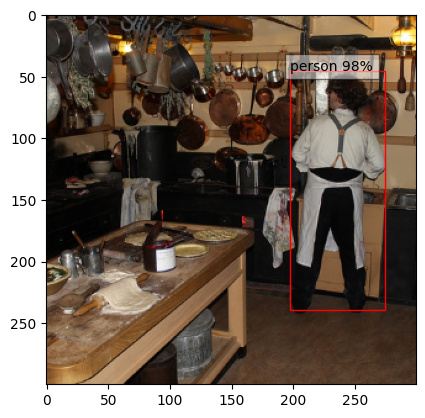

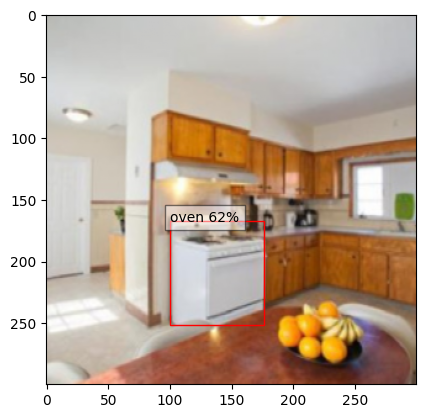

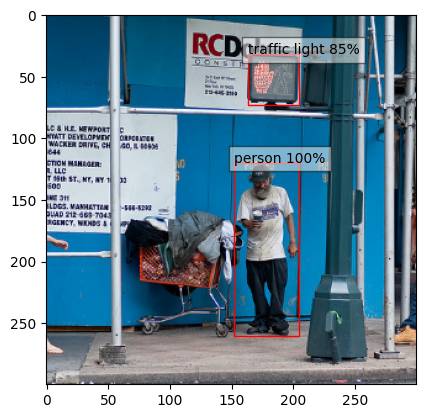

In [11]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

===================실습 코드 활용===================

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [13]:
# 데이터셋을 로드하고 전처리합니다.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# CIFAR-10 데이터셋을 다운로드하고 로드합니다.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 29455857.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [14]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [16]:
# torchvision.models 모듈을 사용하여 사전 정의된 CNN 모델을 불러옵니다.
import torchvision.models as models

# Pretrained VGG16 모델 사용 (사전 훈련된 가중치 사용)
model = models.vgg16(pretrained=True)

# CIFAR-10 데이터셋의 클래스 수에 맞게 마지막 레이어를 수정합니다.
model.classifier[6] = nn.Linear(4096, 10)

In [17]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
# GPU가 사용 가능한지 확인하고, 사용할 수 있다면 device를 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:0


In [19]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [20]:
# 모델 훈련 함수
def train_model(model, trainloader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 순전파, 역전파, 최적화
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 손실 출력
            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

In [21]:
# 모델 평가 함수
def evaluate_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

In [22]:
model = model.to(device)

In [23]:
# 모델 훈련
train_model(model, trainloader, criterion, optimizer, num_epochs=1)

[Epoch 1, Batch 2000] loss: 0.796
Finished Training


In [24]:
# 모델 평가
evaluate_model(model, testloader)

Accuracy of the network on the 10000 test images: 80.41%


In [ ]:
import torch.nn.functional as F  # F를 nn.functional 모듈로 임포트
# 직접 구현한 CNN 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 첫 번째 합성곱 층: 입력 채널 3, 출력 채널 6, 커널 크기 5
        self.pool = nn.MaxPool2d(2, 2)   # 최대 풀링 층: 커널 크기 2, 스트라이드 2
        self.conv2 = nn.Conv2d(6, 16, 5) # 두 번째 합성곱 층: 입력 채널 6, 출력 채널 16, 커널 크기 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 첫 번째 완전 연결 층: 입력 크기 16*5*5, 출력 크기 120
        self.fc2 = nn.Linear(120, 84)         # 두 번째 완전 연결 층: 입력 크기 120, 출력 크기 84
        self.fc3 = nn.Linear(84, 10)          # 세 번째 완전 연결 층: 입력 크기 84, 출력 크기 10 (클래스 수)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 첫 번째 합성곱 층 -> ReLU -> 풀링
        x = self.pool(F.relu(self.conv2(x))) # 두 번째 합성곱 층 -> ReLU -> 풀링
        x = x.view(-1, 16 * 5 * 5)           # 특성 맵을 1차원 벡터로 변환
        x = F.relu(self.fc1(x))              # 첫 번째 완전 연결 층 -> ReLU
        x = F.relu(self.fc2(x))              # 두 번째 완전 연결 층 -> ReLU
        x = self.fc3(x)                      # 세 번째 완전 연결 층
        return x

In [ ]:
# 모델 인스턴스 생성
net = Net()

In [ ]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
net = net.to(device)

In [ ]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# 모델 훈련
train_model(net, trainloader, criterion, optimizer, num_epochs=10)

[Epoch 1, Batch 2000] loss: 1.654
[Epoch 2, Batch 2000] loss: 1.423
[Epoch 3, Batch 2000] loss: 1.270
[Epoch 4, Batch 2000] loss: 1.181
[Epoch 5, Batch 2000] loss: 1.108
[Epoch 6, Batch 2000] loss: 1.048
[Epoch 7, Batch 2000] loss: 0.997
[Epoch 8, Batch 2000] loss: 0.953
[Epoch 9, Batch 2000] loss: 0.912
[Epoch 10, Batch 2000] loss: 0.874
Finished Training


In [ ]:
# 모델 평가
evaluate_model(net, testloader)

Accuracy of the network on the 10000 test images: 64.89%


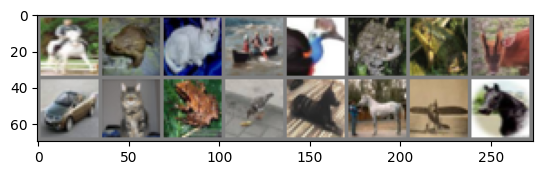

horse frog  cat   ship  bird  frog  frog  deer  car   cat   frog  bird  dog   horse plane horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))